In [1]:
###SASSIE uCTD DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import requests


##LOCAL DIRECTORY TO uCTD DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/uCTD/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIP TRACK DATA
ship_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/uCTD/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

In [2]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
file = (dir_in + 'SASSIE_Fall_2022_shipboard_underwayCTD_new.nc')
    
#SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
ds = xr.open_dataset(file)
#print(ds)

#SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
variable_info = ds.salinity
#print(variable_info)

In [3]:
#play start and end dates  
play1_start = datetime(2022,9,8,8) 
play1_end = datetime(2022,9,13)
play2_start = datetime(2022,9,14)
play2_end = datetime(2022,9,16)
play3_start = datetime(2022,9,16)
play3_end = datetime(2022,9,18)
play4_start = datetime(2022,9,19)
play4_end  = datetime(2022,9,23)
play5_start = datetime(2022,9,25)
play5_end = datetime(2022,9,29)

play_start_dates = [play1_start,play2_start,play3_start,play4_start,play5_start,play1_start]
play_end_dates = [play1_end,play2_end,play3_end,play4_end,play5_end,play5_end]

In [4]:
def define_variable_attributes(var):
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    return colormap,var_label

In [7]:
#PLOT THE LOCATION OF THE CTD CASTS ON THE SHIP TRACK 
def map_cast_location(ship_track=True,ice_data=False,bathymetry_data=True):

    #LOAD UCTD DATA
    uCTD_time = np.squeeze(ds['time'])
    uCTD_lat = np.squeeze(ds['latitude'])
    uCTD_lon = np.squeeze(ds['longitude'])
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS  
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-144
        
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) 
    ax.set_title('uCTD Deployment Locations',fontsize=22,pad=1) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    plt.legend(loc=2)
    
    
    ##OPTIONAL MAP ADD-ONs
    
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        
        track = ax.plot(ship_lon, 
                 ship_lat,linewidth = 0.5,
                 c='black',
                   transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
    
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
    
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(min(uCTD_time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(max(uCTD_time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(str(ice_dir+filename_si, 'wb')) as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
    
    #uCTD locations
    casts = ax.scatter(uCTD_lon,uCTD_lat,s = 10,
                       c = uCTD_time,cmap = 'jet',
                       transform=cartopy.crs.PlateCarree(),zorder=2,
                      vmin=min(uCTD_time.values), vmax=max(uCTD_time.values))
                        
    cbar = fig.colorbar(casts, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(ds['time'].values[0].astype('int64'),ds['time'].values[-1].astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
    
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'deployment_map/'):
        os.makedirs(fig_dir+'deployment_map/')
    
    print('Saving Output Image:  '+fig_dir+'deployment_map/uCTD_deployment_map.png')
    plt.savefig(fig_dir+'deployment_map/uCTD_deployment_map.png',dpi='figure',format='png',bbox_inches='tight')
    
    


TypeError: decoding str is not supported

/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


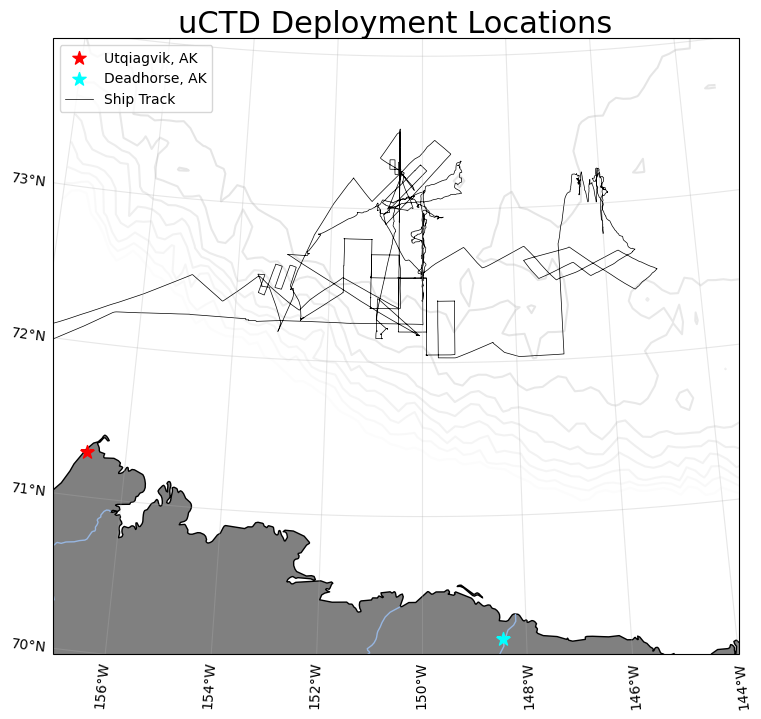

In [9]:
map_cast_location(ice_data=True)

In [ ]:
##USE TO PLOT THE PROFILES TAKEN WITHIN A DATE RANGE 
def uCTD_profiles(start_date,end_date,var,ship_track=True):
    
    #GET UCTD DATA
    selected_casts = ds.sel(time=slice(start_date,end_date))
    CTD_lat = selected_casts['latitude']
    CTD_lon = selected_casts['longitude']
    CTD_pres = selected_casts['pressure']
    CTD_var = selected_casts[var]
    
    [pres,lat] = np.meshgrid(CTD_pres,CTD_lat)
    [pres,lon] = np.meshgrid(CTD_pres,CTD_lon)
    


    ##CREATE 3D PLOT 
    colormap,var_label = define_variable_attributes(var)

    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(CTD_lat.values)
    latmax = max(CTD_lat.values)
    lonmin = min(CTD_lon.values)
    lonmax = max(CTD_lon.values)
    pmin = min(CTD_pres.values)
    pmax = max(CTD_pres.values)+0.5
    
      
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False    
    
    ax.set_title('uCTD'+' '+var_label+' '+'from'+' '+str(start_date.year)+'/'+str(start_date.month).zfill(2)+'/'+str(start_date.day).zfill(2)+' '+str(start_date.hour).zfill(2)+':'+str(start_date.minute).zfill(2)+' to '+str(end_date.year)+'/'+str(end_date.month).zfill(2)+'/'+str(end_date.day).zfill(2)+' '+str(end_date.hour).zfill(2)+':'+str(end_date.minute).zfill(2),fontsize=15,pad=None)

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(pmin,pmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(pmin,pmax,4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Pressure (dbar)')
    ax.view_init(210,60)

        
    ##APPLY CTD DATA   
    a = ax.scatter(lon,lat,pres,c=(CTD_var.values),cmap = colormap,s=2,zorder=1)    
    fig.colorbar(a,label = var_label)
    
    if ship_track==True:
        #LOAD SHIP TRACK DATA
        ds_ship_all = xr.open_dataset(ship_dir)
        ds_ship = ds.sel(time=slice(start_date,end_date))
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,
                     c='black',label = 'Ship Track',zorder=1)

    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+var+'/'):
        os.makedirs(fig_dir+var+'/')
    
    print('Saving Output Image:  '+fig_dir+var+'/'+'uCTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+var+'/'+'uCTD'+var+str(start_date.year)+str(start_date.month).zfill(2)+str(start_date.day).zfill(2)+str(start_date.hour).zfill(2)+str(start_date.minute).zfill(2)+'_'+str(end_date.year)+str(end_date.month).zfill(2)+str(end_date.day).zfill(2)+str(end_date.hour).zfill(2)+str(end_date.minute).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')
    

In [ ]:
uCTD_profiles(play1_start,play1_end,'temperature')
uCTD_profiles(play2_start,play2_end,'temperature')
uCTD_profiles(play3_start,play3_end,'temperature')
uCTD_profiles(play4_start,play4_end,'temperature')
uCTD_profiles(play5_start,play5_end,'temperature')

In [ ]:
uCTD_profiles(play1_start,play1_end,'salinity')
uCTD_profiles(play2_start,play2_end,'salinity')
uCTD_profiles(play3_start,play3_end,'salinity')
uCTD_profiles(play4_start,play4_end,'salinity')
uCTD_profiles(play5_start,play5_end,'salinity')

In [ ]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SEPERATE AXIS)
def plot_cast_profile_by_index_1(cast_number):
    
    #LOAD uCTD DATA 
    uCTD_sal = np.squeeze(ds['salinity'].values[cast_number,:])
    uCTD_temp = np.squeeze(ds['temperature'].values[cast_number,:])
    uCTD_pres = np.squeeze(ds['pressure'].values)
    uCTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    
    ## PLOT THE DATA
    fig,axs = plt.subplots(1,2,sharey=True)
    axs[0].plot(uCTD_temp,uCTD_pres,linewidth=0.4,c='black')
    axs[0].invert_yaxis()
    #axs[0].set_title('Water Temperature ($^{\circ}$C)')
    axs[0].set_xlabel('Temperature ($^{\circ}$C)')
    axs[0].set_ylabel('Pressure (dbar)')
    axs[1].plot(uCTD_sal,uCTD_pres,linewidth=0.4,c='black')
    #axs[1].set_title('Salinity')
    axs[1].set_xlabel('Salinity')
    fig.suptitle('uCTD Profiles from Cast '+str(cast_number)+' on '+str(pd.to_datetime(uCTD_time).year).zfill(2)+'/'+str(pd.to_datetime(uCTD_time).month).zfill(2)+'/'+str(pd.to_datetime(uCTD_time).day).zfill(2)+' at '+str(pd.to_datetime(uCTD_time).hour)+':'+str(pd.to_datetime(uCTD_time).minute)+':'+str(pd.to_datetime(uCTD_time).second))
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(uCTD_time).year)+str(pd.to_datetime(uCTD_time).month).zfill(2)+str(pd.to_datetime(uCTD_time).day).zfill(2)+str(pd.to_datetime(uCTD_time).hour).zfill(2)+str(pd.to_datetime(uCTD_time).minute).zfill(2)+str(pd.to_datetime(uCTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(uCTD_time).year)+str(pd.to_datetime(uCTD_time).month).zfill(2)+str(pd.to_datetime(uCTD_time).day).zfill(2)+str(pd.to_datetime(uCTD_time).hour).zfill(2)+str(pd.to_datetime(uCTD_time).minute).zfill(2)+str(pd.to_datetime(uCTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


In [ ]:
plot_cast_profile_by_index_1(110)

In [ ]:
##USE TO PLOT AN INDIVIDUAL CAST BY CAST NUMBER (SAME_AXIS)
def plot_cast_profile_by_index_2(cast_number):
    
    #LOAD uCTD DATA 
    uCTD_sal = np.squeeze(ds['salinity'].values[cast_number,:])
    uCTD_temp = np.squeeze(ds['temperature'].values[cast_number,:])
    uCTD_pres = np.squeeze(ds['pressure'].values)
    uCTD_time = np.squeeze(ds['time'].values[cast_number]).astype('int64')
    
    ## PLOT THE DATA
    fig,ax1 = plt.subplots()
    ax2 = ax1.twiny()
    ax1.plot(uCTD_temp,uCTD_pres,linewidth=0.4,c='blue')
    ax1.invert_yaxis()
    ax1.set_xlabel('Temperature ($^{\circ}$C)',color = 'blue')
    ax1.set_ylabel('Depth (m)')
    ax2.plot(uCTD_sal,uCTD_pres,linewidth=0.4,c='red')
    ax2.set_xlabel('Salinity',color ='red')    
    fig.suptitle('uCTD Profiles from Cast '+str(cast_number)+' on '+str(pd.to_datetime(uCTD_time).year).zfill(2)+'/'+str(pd.to_datetime(uCTD_time).month).zfill(2)+'/'+str(pd.to_datetime(uCTD_time).day).zfill(2)+' at '+str(pd.to_datetime(uCTD_time).hour).zfill(2)+':'+str(pd.to_datetime(uCTD_time).minute).zfill(2)+':'+str(pd.to_datetime(uCTD_time).second).zfill(2),y=1.01)
    
    ## SAVE THE FIGURE
    if not os.path.exists(fig_dir+'profiles/'):
        os.makedirs(fig_dir+'profiles/')
    print('Saving Output Image:  '+fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(uCTD_time).year)+str(pd.to_datetime(uCTD_time).month).zfill(2)+str(pd.to_datetime(uCTD_time).day).zfill(2)+str(pd.to_datetime(uCTD_time).hour).zfill(2)+str(pd.to_datetime(uCTD_time).minute).zfill(2)+str(pd.to_datetime(uCTD_time).second).zfill(2)+'.png')
    plt.savefig(fig_dir+'profiles/'+'uCTD_profile'+str(cast_number)+'_'+str(pd.to_datetime(uCTD_time).year)+str(pd.to_datetime(uCTD_time).month).zfill(2)+str(pd.to_datetime(uCTD_time).day).zfill(2)+str(pd.to_datetime(uCTD_time).hour).zfill(2)+str(pd.to_datetime(uCTD_time).minute).zfill(2)+str(pd.to_datetime(uCTD_time).second).zfill(2)+'.png',dpi='figure',format='png',bbox_inches='tight')


In [ ]:
plot_cast_profile_by_index_2(110)